# Flight Delays Classification WIP

In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold, cross_val_score
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.tree import export_graphviz, plot_tree
from catboost import CatBoostClassifier
from hyperopt import hp, STATUS_OK, Trials, fmin, tpe

RANDOM_STATE = 42

In [55]:
df_train_original = pd.read_csv('flight-delays-spring-2018/flight-delays/flight_delays_train.csv')
df_test_original = pd.read_csv('flight-delays-spring-2018/flight-delays/flight_delays_test.csv')

## EDA

- Month, DayofMonth, DayOfWeek
- DepTime – departure time
- UniqueCarrier – code of a company-career
- Origin – flight origin
- Dest – flight destination
- Distance, distance between Origin and Dest airports
- dep_delayed_15min – target

In [56]:
df_train_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Month              100000 non-null  object
 1   DayofMonth         100000 non-null  object
 2   DayOfWeek          100000 non-null  object
 3   DepTime            100000 non-null  int64 
 4   UniqueCarrier      100000 non-null  object
 5   Origin             100000 non-null  object
 6   Dest               100000 non-null  object
 7   Distance           100000 non-null  int64 
 8   dep_delayed_15min  100000 non-null  object
dtypes: int64(2), object(7)
memory usage: 6.9+ MB


In [57]:
df_train_original.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y


First, we will remove the trash that doesn't add any informaation from the categorical values related to the date

In [58]:
def clean_dataset(df: pd.DataFrame):
  df = df.copy()
  df['Month'] = df['Month'].apply(lambda x: int(x[2:]))
  df['DayofMonth'] = df['DayofMonth'].apply(lambda x: int(x[2:]))
  df['DayOfWeek'] = df['DayOfWeek'].apply(lambda x: int(x[2:]))

  return df

In [59]:
df_train = clean_dataset(df_train_original)
df_train.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,8,21,7,1934,AA,ATL,DFW,732,N
1,4,20,3,1548,US,PIT,MCO,834,N
2,9,2,5,1422,XE,RDU,CLE,416,N
3,11,25,6,1015,OO,DEN,MEM,872,N
4,10,7,6,1828,WN,MDW,OMA,423,Y


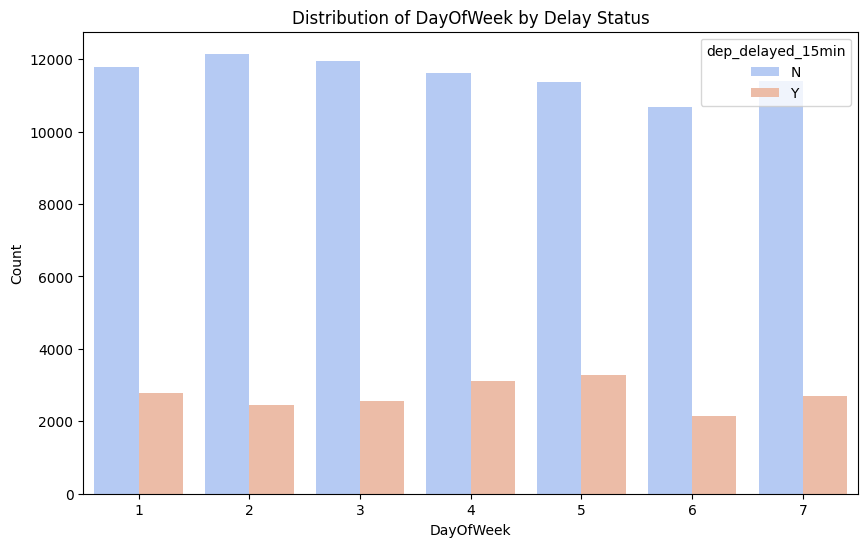

In [60]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df_train, x='DayOfWeek', hue='dep_delayed_15min', palette='coolwarm')
plt.title(f'Distribution of DayOfWeek by Delay Status')
plt.xlabel('DayOfWeek')
plt.ylabel('Count')
plt.show()

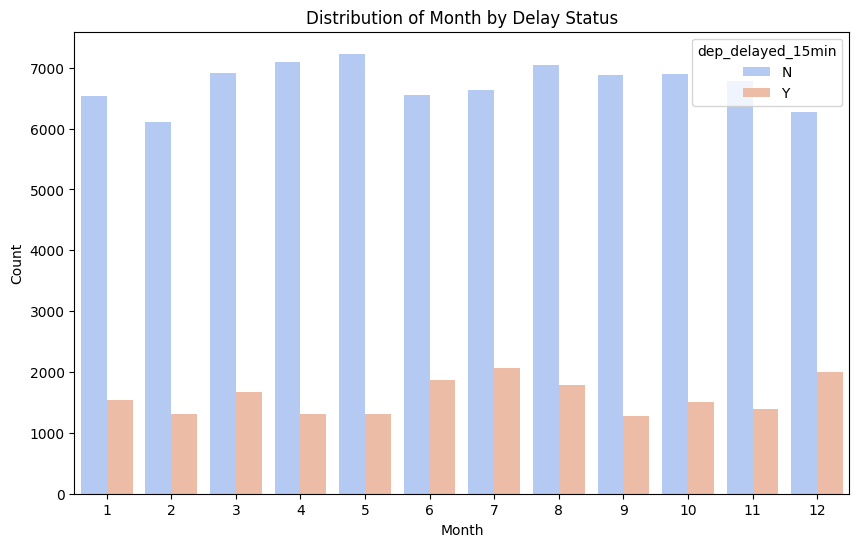

In [61]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df_train, x='Month', hue='dep_delayed_15min', palette='coolwarm')
plt.title(f'Distribution of Month by Delay Status')
plt.xlabel('Month')
plt.ylabel('Count')
plt.show()

Months with most delays are july and december, commonly vacation months worldwide

In [62]:
def clean_and_engineer_features(df: pd.DataFrame):
  df = df.copy()

  df['dep_delayed_15min'].replace({'N': 0, 'Y': 1}, inplace=True) if 'dep_delayed_15min' in df.columns else None

  df['DepartureHour'] =  df['DepTime'] // 100
  df['DepartureMinute'] =  df['DepTime'] % 100
  df.drop('DepTime', inplace=True, axis=1)

  df['OriginAndDest'] = df['Origin'] + "_" + df['Dest']
  df['CarrierAndOrigin'] = df['UniqueCarrier'] + "_" + df['Origin']
  df['CarrierAndDest'] = df['UniqueCarrier'] + "_" + df['Dest']

  return df

/var/folders/jq/tdq0h8rj1zdbxsbs18vhfp0h0000gp/T/ipykernel_2401/2163709429.py:4: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/var/folders/jq/tdq0h8rj1zdbxsbs18vhfp0h0000gp/T/ipykernel_2401/2163709429.py:4: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



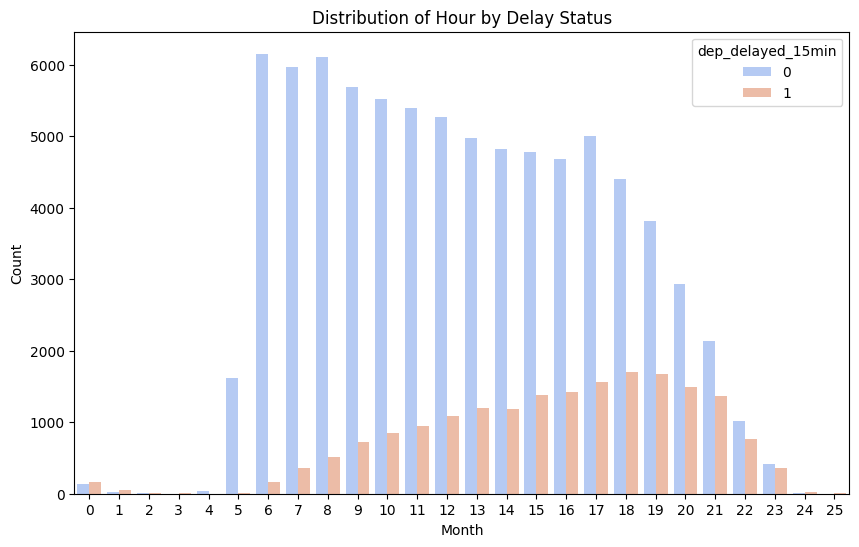

In [63]:
plt.figure(figsize=(10, 6))
sns.countplot(data=clean_and_engineer_features(df_train), x='DepartureHour', hue='dep_delayed_15min', palette='coolwarm')
plt.title(f'Distribution of Hour by Delay Status')
plt.xlabel('Month')
plt.ylabel('Count')
plt.show()

We can see from the graph above that the possible 'rush hour' in aviation, when more delays occur, increases throughout the day and reaches its peak for evening flights, between 6 PM and 7 PM

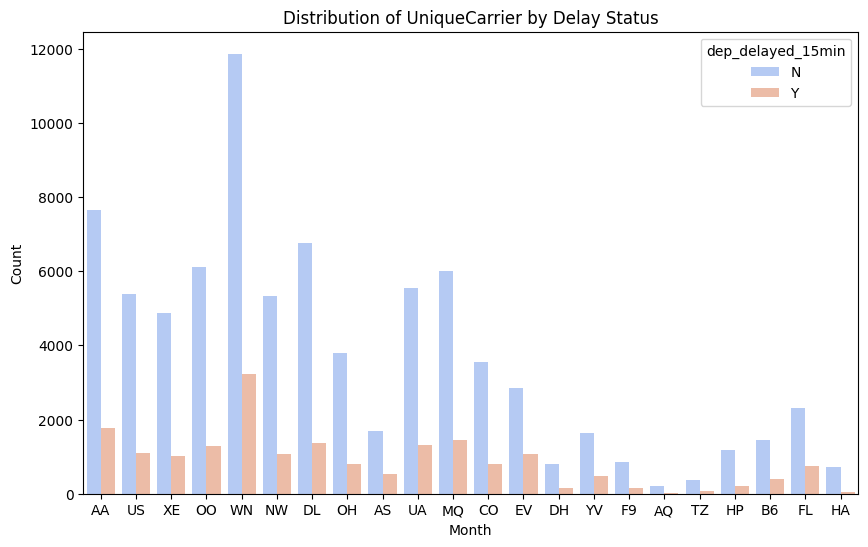

In [64]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df_train, x='UniqueCarrier', hue='dep_delayed_15min', palette='coolwarm')
plt.title(f'Distribution of UniqueCarrier by Delay Status')
plt.xlabel('Month')
plt.ylabel('Count')
plt.show()

## CatBoostClassification

#### Preprocessing

In [65]:
def catboost_preprocessing(df: pd.DataFrame):
  df = df.copy()

  df['dep_delayed_15min'].replace({'N': 0, 'Y': 1}, inplace=True) if 'dep_delayed_15min' in df.columns else None

  df['Month'] = df['Month'].apply(lambda x: int(x[2:]))
  df['DayofMonth'] = df['DayofMonth'].apply(lambda x: int(x[2:]))
  df['DayOfWeek'] = df['DayOfWeek'].apply(lambda x: int(x[2:]))

  df['DepartureHour'] =  df['DepTime'] // 100

  df['Route'] = df['Origin'] + "_" + df['Dest']
  df['CarrierAndOrigin'] = df['UniqueCarrier'] + "_" + df['Origin']
  df['CarrierAndDest'] = df['UniqueCarrier'] + "_" + df['Dest']
  df['CarrierAndHour'] = df['UniqueCarrier'] + "_" + df['DepartureHour'].astype('str')
  df['RouteAndHour'] = df['Route'] + "_" + df['DepartureHour'].astype('str')
  df['DepartureHour'] = df['DepartureHour'].astype('str')
  df['CarrierAndDistance'] = df['UniqueCarrier'] + "_" + df['Distance'].astype('str')
  df['CarrierAndDayOfWeek'] = df['UniqueCarrier'] + "_" + df['DayOfWeek'].astype('str')

  return df

In [66]:
df_train_original.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y


In [67]:
df_train_cb = catboost_preprocessing(df_train_original)
df_train_cb.head()

/var/folders/jq/tdq0h8rj1zdbxsbs18vhfp0h0000gp/T/ipykernel_2401/3152183751.py:4: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/var/folders/jq/tdq0h8rj1zdbxsbs18vhfp0h0000gp/T/ipykernel_2401/3152183751.py:4: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min,DepartureHour,Route,CarrierAndOrigin,CarrierAndDest,CarrierAndHour,RouteAndHour,CarrierAndDistance,CarrierAndDayOfWeek
0,8,21,7,1934,AA,ATL,DFW,732,0,19,ATL_DFW,AA_ATL,AA_DFW,AA_19,ATL_DFW_19,AA_732,AA_7
1,4,20,3,1548,US,PIT,MCO,834,0,15,PIT_MCO,US_PIT,US_MCO,US_15,PIT_MCO_15,US_834,US_3
2,9,2,5,1422,XE,RDU,CLE,416,0,14,RDU_CLE,XE_RDU,XE_CLE,XE_14,RDU_CLE_14,XE_416,XE_5
3,11,25,6,1015,OO,DEN,MEM,872,0,10,DEN_MEM,OO_DEN,OO_MEM,OO_10,DEN_MEM_10,OO_872,OO_6
4,10,7,6,1828,WN,MDW,OMA,423,1,18,MDW_OMA,WN_MDW,WN_OMA,WN_18,MDW_OMA_18,WN_423,WN_6


In [68]:
df_train_cb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   Month                100000 non-null  int64 
 1   DayofMonth           100000 non-null  int64 
 2   DayOfWeek            100000 non-null  int64 
 3   DepTime              100000 non-null  int64 
 4   UniqueCarrier        100000 non-null  object
 5   Origin               100000 non-null  object
 6   Dest                 100000 non-null  object
 7   Distance             100000 non-null  int64 
 8   dep_delayed_15min    100000 non-null  int64 
 9   DepartureHour        100000 non-null  object
 10  Route                100000 non-null  object
 11  CarrierAndOrigin     100000 non-null  object
 12  CarrierAndDest       100000 non-null  object
 13  CarrierAndHour       100000 non-null  object
 14  RouteAndHour         100000 non-null  object
 15  CarrierAndDistance   100000 non-nul

#### Hyperparameter tuning

In [69]:
X_cb = df_train_cb.drop("dep_delayed_15min", axis=1)
y_cb = df_train_cb.dep_delayed_15min

categorical_feats = X_cb.select_dtypes(include=["object"]).columns.tolist()

In [72]:
# hyperparameter search space
space = {
    'depth': hp.quniform("depth", 3, 18),
    'learning_rate': hp.uniform("learning_rate", 0.01, 0.9),
    'subsample': hp.quniform("subsample", 0.5, 1.0, 0.1),
    'n_estimators': hp.quniform("n_estimators", 150, 250, 20),
}

# objective function that returns the score
def objective(space):
    clf = CatBoostClassifier(
        depth = int(space['depth']),
        learning_rate = space['learning_rate'],
        subsample = space['subsample'],
        early_stopping_rounds=10,
        random_state = RANDOM_STATE,
        verbose=1,
        cat_features=categorical_feats,
        n_estimators = int(space['n_estimators']),
        thread_count=12
    )

    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=RANDOM_STATE)
    n_scores = cross_val_score(clf, X_cb, y_cb, scoring='roc_auc', cv=cv, n_jobs=-1, error_score='raise')

    loss = 1 - n_scores.mean()
    print ("SCORE:", loss)
    return {"loss": loss, "model": clf, "status": STATUS_OK}

trials = Trials()
best_hyperparams = fmin(
    fn = objective,
    space = space,
    algo = tpe.suggest,
    max_evals = 1000,
    trials = trials
)

  0%|                                  | 0/1000 [00:00<?, ?trial/s, best loss=?]


TypeError: ap_quniform_sampler() missing 1 required positional argument: 'q'

In [ ]:
best_catboost, best_loss = trials.best_trial["result"]["model"], trials.best_trial["result"]["loss"]

print(f'ROC-AUC Score: {1 - best_loss}')

ROC-AUC Score: 0.7925


#### ROC Curve

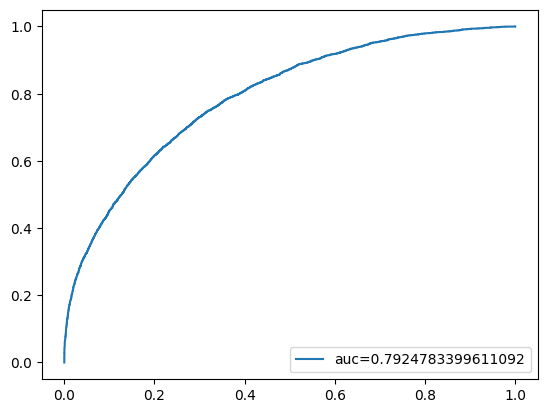

In [ ]:
# import scikitplot as skplt
import matplotlib.pyplot as plt

# print(y_test)
# y_pred_proba

fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="auc="+str(auc))
plt.legend(loc=4)
plt.show()

## Submission

In [ ]:
df_test_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Month          100000 non-null  object
 1   DayofMonth     100000 non-null  object
 2   DayOfWeek      100000 non-null  object
 3   DepTime        100000 non-null  int64 
 4   UniqueCarrier  100000 non-null  object
 5   Origin         100000 non-null  object
 6   Dest           100000 non-null  object
 7   Distance       100000 non-null  int64 
dtypes: int64(2), object(6)
memory usage: 6.1+ MB


In [ ]:
df_test_processed = catboost_preprocessing(df_test_original)
df_test_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   Month               100000 non-null  object
 1   DayofMonth          100000 non-null  object
 2   DayOfWeek           100000 non-null  object
 3   DepTime             100000 non-null  int64 
 4   UniqueCarrier       100000 non-null  object
 5   Origin              100000 non-null  object
 6   Dest                100000 non-null  object
 7   Distance            100000 non-null  int64 
 8   DepartureHour       100000 non-null  object
 9   Route               100000 non-null  object
 10  CarrierAndOrigin    100000 non-null  object
 11  CarrierAndDest      100000 non-null  object
 12  CarrierAndHour      100000 non-null  object
 13  RouteAndHour        100000 non-null  object
 14  CarrierAndDistance  100000 non-null  object
dtypes: int64(2), object(13)
memory usage: 11.4+ MB


In [ ]:
y_pred_proba = catboost_clf.predict_proba(df_test_processed)[:, 1]  # Probability of class 1 (delayed)

In [ ]:
len(y_pred_proba)

100000

In [ ]:
res = pd.Series(y_pred_proba, name='dep_delayed_15min')
res.head()

0    0.010626
1    0.028549
2    0.033997
3    0.349574
4    0.355114
Name: dep_delayed_15min, dtype: float64

In [ ]:
res.info()

<class 'pandas.core.series.Series'>
RangeIndex: 100000 entries, 0 to 99999
Series name: dep_delayed_15min
Non-Null Count   Dtype  
--------------   -----  
100000 non-null  float64
dtypes: float64(1)
memory usage: 781.4 KB


In [ ]:
pd.Series(y_pred_proba, name='dep_delayed_15min').to_csv('lhcc.csv', index_label='id', header=True)

#### Resultado do Kaggle: 0.73902

Um score roc-auc de 0.73902 aponta que o modelo tem aprox 73.902% de chance de prever uma instancia aleatoria "positiva" corretamente. Na base de treinamento, fazendo holdout e testando com uma porcentagem dos dados de treino, o melhor resultado foi 0.7925, que equivale a aproximadamente 4/5 de probabilidade para essa base. O resultado de treinamento não aponta um possível overfitting e isso foi provado com o resultado de testes que não ficou longe do resultado de treino (apesar de mais baixo), mostrando que foi possível treinar um modelo generalista.